In [1]:
import os
import numpy as np
import pandas as pd
import torch
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_distances
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import shutil
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification
from PIL import Image
import yaml
import random
from torchvision import transforms

# === Загрузка настроек ===
with open('parametrs.yaml', 'r', encoding='utf-8') as f:
    config = yaml.safe_load(f)

# === Установка сидов ===
seed = config['experiment']['seed']
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# === Устройство ===
device = torch.device(config['training']['device'] if torch.cuda.is_available() else "cpu")

# === Загрузка модели ViT ===
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=3)
checkpoint_path = "checkpoints/cosin/cosin_vit_fold1.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.to(device)
model.eval()

# === Датасет и загрузчик ===
class FundusDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, root_dir, config):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.config = config

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_name = row['image_name']
        label = int(row['true_label'])
        img_path = os.path.join(self.root_dir, str(label), img_name)
        image = Image.open(img_path).convert("RGB")
        
        transform = get_transform_pipeline(self.config, label=label)
        image = transform(image)

        return image, label, img_name

def get_transform_pipeline(config, label=None):
    transform_list = []
    transform_list.append(transforms.Resize(config['dataset']['image_size']))
    transform_list.extend([transforms.ToTensor(), transforms.Normalize(mean=config['dataset']['mean'], std=config['dataset']['std'])])
    return transforms.Compose(transform_list)

# Загрузка данных
train_df = pd.read_csv('D:/dataset/_eyepacs/data/filtered_data_with_cosine/train_all_image.csv')
root_dir = 'D:/dataset/_eyepacs/data/filtered_data_with_cosine/train_old'

train_dataset = FundusDataset(train_df, root_dir=root_dir, config=config)
train_loader = DataLoader(train_dataset, batch_size=config['training']['batch_size'], shuffle=False)

# === Извлечение эмбеддингов ===
embeddings = []
labels = []
image_paths = []

with torch.no_grad():
    for images, batch_labels, paths in train_loader:
        images = images.to(device)
        outputs = model(pixel_values=images, output_hidden_states=True)
        batch_embeddings = outputs.hidden_states[-1][:, 0, :].cpu().numpy()
        
        embeddings.extend(batch_embeddings)
        labels.extend(batch_labels.numpy())
        image_paths.extend(paths)

embeddings = np.array(embeddings)

d:\dataset\dataset_create\pythonProject\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
from sklearn.metrics.pairwise import cosine_distances
import os
import shutil

# Преобразуем в массивы для удобства
labels = np.array(labels)
image_paths = np.array(image_paths)

# Получим эмбеддинги по классам
emb_0 = embeddings[labels == 0]
emb_1 = embeddings[labels == 1]
emb_2 = embeddings[labels == 2]

# Для каждого emb из класса 0 считаем среднее расстояние до emb классов 1 и 2
dists_to_1 = cosine_distances(emb_0, emb_1).mean(axis=1)
dists_to_2 = cosine_distances(emb_0, emb_2).mean(axis=1)
avg_dists = (dists_to_1 + dists_to_2) / 2

# Чем меньше расстояние — тем "ближе" образец к другим классам
top_k_idx = np.argsort(avg_dists)[:6260]  # Выбираем самые "сложные" 6260

# Получаем имена файлов
selected_images = image_paths[labels == 0][top_k_idx]

# Копируем в новую директорию
destination_dir = "D:/dataset/_eyepacs/data/filtered_data_with_cosine/strong/train/0"
os.makedirs(destination_dir, exist_ok=True)

source_dir = os.path.join(root_dir, "0")
for img_name in selected_images:
    src_path = os.path.join(source_dir, img_name)
    dst_path = os.path.join(destination_dir, img_name)
    if os.path.exists(src_path):
        shutil.copy2(src_path, dst_path)


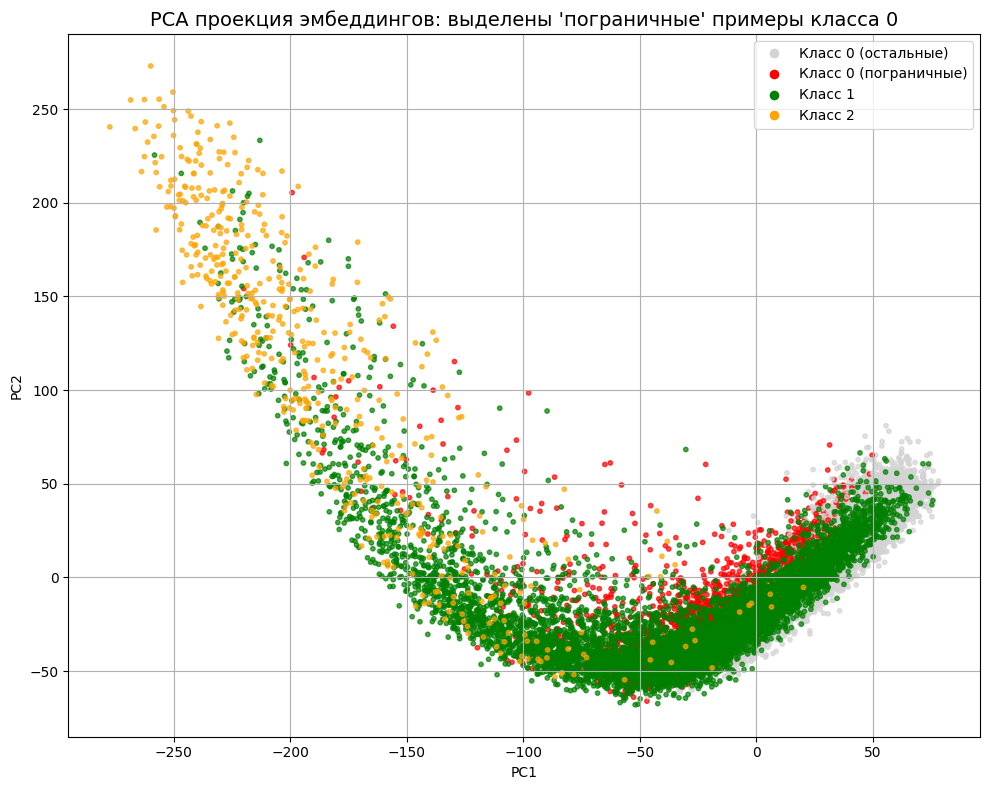

In [3]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Предполагаем, что переменные уже заданы:
# embeddings, labels, selected_images (из предыдущего кода)

# Преобразуем в массивы
labels_np = np.array(labels)
image_paths_np = np.array(image_paths)

# Определим, какие из изображений класса 0 были выбраны как "пограничные"
selected_set = set(selected_images)
is_selected = np.array([img in selected_set for img in image_paths_np[labels_np == 0]])

# Подготовим данные для PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Цвета: 0 - серый, 1 - зелёный, 2 - оранжевый, выбраные 0 - красный
colors = []
for i, label in enumerate(labels_np):
    if label == 0 and image_paths_np[i] in selected_set:
        colors.append("red")
    elif label == 0:
        colors.append("lightgray")
    elif label == 1:
        colors.append("green")
    else:
        colors.append("orange")

# Визуализация
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors, s=10, alpha=0.7)
plt.title("PCA проекция эмбеддингов: выделены 'пограничные' примеры класса 0", fontsize=14)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', label='Класс 0 (остальные)', markerfacecolor='lightgray', markersize=8),
    plt.Line2D([0], [0], marker='o', color='w', label='Класс 0 (пограничные)', markerfacecolor='red', markersize=8),
    plt.Line2D([0], [0], marker='o', color='w', label='Класс 1', markerfacecolor='green', markersize=8),
    plt.Line2D([0], [0], marker='o', color='w', label='Класс 2', markerfacecolor='orange', markersize=8)
])
plt.tight_layout()
plt.show()


In [2]:
import os
import pandas as pd
from tqdm import tqdm

# Путь к новой папке
base_dir = "D:/dataset/_eyepacs/data/filtered_data_with_cosine/strong/train"

# Список для записи информации
records = []

# Проходим по каждому классу (0, 1, 2)
for class_label in ['0', '1', '2']:
    class_dir = os.path.join(base_dir, class_label)
    if not os.path.exists(class_dir):
        print(f"Папка не найдена: {class_dir}")
        continue
    for img_name in tqdm(os.listdir(class_dir), desc=f"Класс {class_label}"):
        if img_name.endswith(('.png', '.jpg', '.jpeg')):  # Только картинки
            records.append({
                'image_name': img_name,
                'true_label': int(class_label)
            })

# Создание DataFrame
new_df = pd.DataFrame(records)

# Перемешать строки
new_df = new_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Сохранение
save_path = "D:/dataset/_eyepacs/data/filtered_data_with_cosine/strong/train_strong.csv"
new_df.to_csv(save_path, index=False)

print(f"Новый датасет сохранён: {save_path}")
print(new_df['true_label'].value_counts())


Класс 2: 100%|██████████| 6260/6260 [00:00<00:00, 1044155.85it/s]

Новый датасет сохранён: D:/dataset/_eyepacs/data/filtered_data_with_cosine/strong/train_strong.csv
true_label
1    6260
2    6260
0    6260
Name: count, dtype: int64
